In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import os
import gc
print(os.listdir("../input/ieee-fraud-detection/"))
pd.options.display.max_rows = 99
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

['test_identity.csv', 'sample_submission.csv', 'train_identity.csv', 'train_transaction.csv', 'test_transaction.csv']


In [2]:
train = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv', index_col ='TransactionID')
test = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv', index_col ='TransactionID')
train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv', index_col = 'TransactionID')
test_id = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv', index_col = 'TransactionID')

In [3]:
# column Type을 다시 지정해주자 
#https://www.kaggle.com/mhviraf/reducing-memory-size-an-alternative
# NaN 이 포함된 int value도 float으로 되어 있고, 이를 Reduce mem usuage 사용하면 데이터 손실이 발생하기도 한다.V
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    del_cols = ['TransactionAmt','dist1', 'dist2', 'C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'D8', 'D9', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V150', 'V159', 'V164', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V332', 'V334', 'V335', 'V336']
    
    cols = [x for x in list(df.columns) if x not in del_cols]# 데이터가 변경되는 컬럼은 제외 81개
    for col in tqdm(cols):
#         if col in cols : continue 
        col_type = df[col].dtype
        #print(col_type)
#         if str(col_type)[:4]== 'date' : continue
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
train_id = reduce_mem_usage(train_id)
test_id = reduce_mem_usage(test_id)
gc.collect()

  1%|          | 3/312 [00:00<00:19, 16.19it/s]

Memory usage of dataframe is 1775.15 MB


  1%|          | 2/311 [00:00<00:23, 13.11it/s]

Memory usage after optimization is: 722.57 MB
Decreased by 59.3%
Memory usage of dataframe is 1519.24 MB


 30%|███       | 12/40 [00:00<00:00, 105.77it/s]

Memory usage after optimization is: 619.49 MB
Decreased by 59.2%
Memory usage of dataframe is 45.12 MB


 30%|███       | 12/40 [00:00<00:00, 102.99it/s]

Memory usage after optimization is: 10.57 MB
Decreased by 76.6%
Memory usage of dataframe is 44.39 MB


100%|██████████| 40/40 [00:00<00:00, 58.66it/s]

Memory usage after optimization is: 10.40 MB
Decreased by 76.6%


0

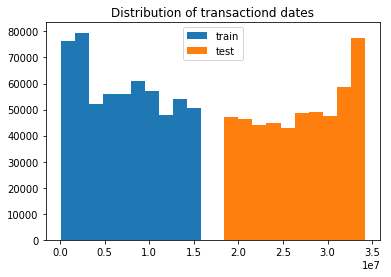

In [5]:
# TransactionDT를 Time으로 전환하기
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');
plt.show()

import datetime
# Train 데이터: 2월~7월(6개월) , test 데이터 :9월~2월
# 1,2,3월에 transaction이 많다.
# 매달 말일의 fraud 비율이 높다. 25~31일 을 1로 치환하자
startdate= '2017-11-30'
startdate= datetime.datetime.strptime(startdate,'%Y-%M-%d')

train['date']= train['TransactionDT'].map(lambda x : (startdate+datetime.timedelta(seconds=x)))
test['date']= test['TransactionDT'].map(lambda x : (startdate+datetime.timedelta(seconds=x)))

train['dayofyear'] =  train['date'].dt.dayofyear
test['dayofyear'] =  test['date'].dt.dayofyear

train['day'] = train['date'].dt.day
test['day'] = test['date'].dt.day

train['hours'] = train['date'].dt.hour
test['hours'] = test['date'].dt.hour

train['weekdays'] = train['date'].dt.dayofweek
test['weekdays'] = test['date'].dt.dayofweek

train['week'] = train['date'].dt.week
test['week'] = test['date'].dt.week

train['month'] = train['date'].dt.month
test['month'] = test['date'].dt.month

In [6]:
train['fromstart']= (train['TransactionDT']/3600/24).astype('int')
test['fromstart']= (test['TransactionDT']/3600/24).astype('int')

In [7]:
from sklearn.decomposition import PCA


lst = list(['V%i'%i for i in range(1,12)])
cols = ['PCA1_V1_11','PCA2_V1_11','PCA3_V1_11','PCA4_V1_11','PCA5_V1_11']
pca = PCA(n_components=5)
train = pd.concat([train,pd.DataFrame(pca.fit_transform(train.loc[:,lst].fillna(0)), columns=cols, index=train.loc[:,lst].index)],axis=1)
test =  pd.concat([test,pd.DataFrame(pca.fit_transform(test.loc[:,lst].fillna(0)), columns=cols, index=test.loc[:,lst].index)],axis=1)

# lst = ['V%i'%i for i in range(12,35)]
lst = list(['V%i'%i for i in range(12,35)])
cols = ['PCA1_V12_34','PCA2_V12_34','PCA3_V12_34','PCA4_V12_34','PCA5_V12_34']
pca = PCA(n_components=5)
train = pd.concat([train,pd.DataFrame(pca.fit_transform(train.loc[:,lst].fillna(0)), columns=cols, index=train.loc[:,lst].index)],axis=1)
test =  pd.concat([test,pd.DataFrame(pca.fit_transform(test.loc[:,lst].fillna(0)), columns=cols, index=test.loc[:,lst].index)],axis=1)

# lst = ['V%i'%i for i in range(75,95)]
lst = list(['V%i'%i for i in range(75,95)])
cols = ['PCA1_V75_94','PCA2_V75_94','PCA3_V75_94','PCA4_V75_94','PCA5_V75_94']
pca = PCA(n_components=5)
train = pd.concat([train,pd.DataFrame(pca.fit_transform(train.loc[:,lst].fillna(0)), columns=cols, index=train.loc[:,lst].index)],axis=1)
test =  pd.concat([test,pd.DataFrame(pca.fit_transform(test.loc[:,lst].fillna(0)), columns=cols, index=test.loc[:,lst].index)],axis=1)

gc.collect()
# train

3647

In [8]:
train['V1_11'] = ''
test['V1_11'] = ''
for col in ['V%i'%i for i in range(1,12)]:
    train[col] = train[col].fillna(0)
    train['V1_11'] += train[col].astype('int').astype('str')
    
    test[col] = test[col].fillna(0)
    test['V1_11'] += test[col].astype('int').astype('str')
    

# CV 0.0012 Drop # Test
# train['V12_34'] = ''
# test['V12_34'] = ''
# for col in ['V%i'%i for i in range(12,35)]:
#     train[col] = train[col].fillna(0)
#     train['V12_34'] += train[col].astype('int').astype('str')
#     test[col] = test[col].fillna(0)
#     test['V12_34'] += test[col].astype('int').astype('str')



train['V35_52'] = ''
test['V35_52'] = ''
for col in ['V%i'%i for i in range(35,53)]:
    train[col] = train[col].fillna(0)
    train['V35_52'] += train[col].astype('int').astype('str')
    test[col] = test[col].fillna(0)
    test['V35_52'] += test[col].astype('int').astype('str')


train['V75_94'] = ''
test['V75_94'] = ''
for col in ['V%i'%i for i in range(75,95)]:
    train[col] = train[col].fillna(0)
    train['V75_94'] += train[col].astype('int').astype('str')
    test[col] = test[col].fillna(0)
    test['V75_94'] += test[col].astype('int').astype('str')
    


# train = train.drop(['V%i'%i for i in range(1,12)]+['V%i'%i for i in range(35,95)], axis =1)
# test = test.drop(['V%i'%i for i in range(1,12)]+['V%i'%i for i in range(35,95)], axis =1)

In [9]:
drop_cols = []
#- V126~137(누적 지불액)  / V95~106(누적횟수 조건별) = 평균 지불액
cum_amt = ['V%s'%x for x in range(126,138)]
cum_cnt = ['V%s'%x for x in range(95,107)]
for i in range(len(cum_amt)):
    train['Avg_%s'%cum_amt[i]] = (train[cum_amt[i]]/train[cum_cnt[i]]).fillna(0)
    test['Avg_%s'%cum_amt[i]] = (test[cum_amt[i]]/test[cum_cnt[i]]).fillna(0)
    drop_cols +=[cum_amt[i],cum_cnt[i]]

# # V202~V216 / (V167~V182, V176빼고) = 평균 지불액
# cum_amt = ['V%s'%x for x in range(202,217)]
# cum_cnt = ['V%s'%x for x in range(167,183) if x != 176]
# for i in range(len(cum_amt)):
#     train['Avg_%s'%cum_amt[i]] = (train[cum_amt[i]]/train[cum_cnt[i]]).fillna(0)
#     test['Avg_%s'%cum_amt[i]] = (test[cum_amt[i]]/test[cum_cnt[i]]).fillna(0)
#     drop_cols +=[cum_amt[i],cum_cnt[i]]    
    
# # V263~268 / V217~V222 = 평균 지불액
# cum_amt = ['V%s'%x for x in range(263,269)]
# cum_cnt = ['V%s'%x for x in range(217,223)]
# for i in range(len(cum_amt)):
#     train['Avg_%s'%cum_amt[i]] = (train[cum_amt[i]]/train[cum_cnt[i]]).fillna(0)
#     test['Avg_%s'%cum_amt[i]] = (test[cum_amt[i]]/test[cum_cnt[i]]).fillna(0)
#     drop_cols +=[cum_amt[i],cum_cnt[i]]   
    

# V306/307/308/316/317/318 / V293/294/295
cum_amt = ['V306','V307','V308','V316','V317','V318']
cum_cnt = ['V293','V294','V295','V293','V294','V295']
for i in range(len(cum_amt)):
    train['Avg_%s'%cum_amt[i]] = (train[cum_amt[i]]/train[cum_cnt[i]]).fillna(0)
    test['Avg_%s'%cum_amt[i]] = (test[cum_amt[i]]/test[cum_cnt[i]]).fillna(0)
#     drop_cols +=[cum_amt[i],cum_cnt[i]]  # 누적 횟수/ 누적 거래액을 사용한다 삭제 하지 않고

In [10]:
train['M1_9'] = ''
test['M1_9'] = ''
for x in ['M%s'%i for i in range(1,10) if i !=4]:    
    train[x]=train[x].cat.add_categories("N").fillna('N')
    train['M1_9'] += train[x].astype('str')
    test[x]=test[x].cat.add_categories("N").fillna('N')
    test['M1_9'] += test[x].astype('str')

In [11]:
train['P_emaildomain'].cat.add_categories("NaN").fillna("NaN")
train['R_emaildomain'].cat.add_categories("NaN").fillna("NaN")

test['P_emaildomain'].cat.add_categories("NaN").fillna("NaN")
test['R_emaildomain'].cat.add_categories("NaN").fillna("NaN")

# cardid 생성
train['uid1'] = train['card1'].astype('str')+'-'+train['card2'].astype('str')
train['uid2'] = train['uid1'].astype('str')+'-'+train['card3'].astype('str')
train['uid3'] = train['uid2'].astype('str')+'-'+train['card4'].astype('str')
train['uid4'] = train['uid3'].astype('str')+'-'+train['card5'].astype('str')
train['uid6'] = train['uid4'].astype('str')+'-'+train['card6'].astype('str')
train['uid7'] = train['uid6'].astype('str')+'-'+train['addr1'].astype('str')
train['uid8'] = train['uid7'].astype('str')+'-'+train['addr2'].astype('str')
train['uid9'] = train['uid8'].astype('str')+'-'+train['P_emaildomain'].astype('str')
train['uid10'] = train['uid9'].astype('str')+'-'+train['R_emaildomain'].astype('str')
train['uid11'] = train['uid10'].astype('str')+'-'+train['fromstart'].astype('str')


test['uid1'] = test['card1'].astype('str')+'-'+test['card2'].astype('str')
test['uid2'] = test['uid1'].astype('str')+'-'+test['card3'].astype('str')
test['uid3'] = test['uid2'].astype('str')+'-'+test['card4'].astype('str')
test['uid4'] = test['uid3'].astype('str')+'-'+test['card5'].astype('str')
test['uid6'] = test['uid4'].astype('str')+'-'+test['card6'].astype('str')
test['uid7'] = test['uid6'].astype('str')+'-'+test['addr1'].astype('str')
test['uid8'] = test['uid7'].astype('str')+'-'+test['addr2'].astype('str')
test['uid9'] = test['uid8'].astype('str')+'-'+test['P_emaildomain'].astype('str')
test['uid10'] = test['uid9'].astype('str')+'-'+test['R_emaildomain'].astype('str')
test['uid11'] = test['uid10'].astype('str')+'-'+test['fromstart'].astype('str')
# 삭제 전후 차이 없음??? -- 차이가 크다
# train = train.drop(['card2','card3','card4','card5','card6'], axis =1)
# test = test.drop(['card2','card3','card4','card5','card6'], axis =1)

train['card1_addr1'] = train['card1'].astype('str')+'-'+train['addr1'].astype('str')
test['card1_addr1'] = test['card1'].astype('str')+'-'+test['addr1'].astype('str')

In [12]:
# # Count encoding for card1 feature. 
# # Explained in this kernel: https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
# Drop
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

train['card2_count_full'] = train['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))
test['card2_count_full'] = test['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))

train['card3_count_full'] = train['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))
test['card3_count_full'] = test['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))


train['card4_count_full'] = train['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))
test['card4_count_full'] = test['card4'].map(pd.concat([train['card4'], test['card4']], ignore_index=True).value_counts(dropna=False))

train['card5_count_full'] = train['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))
test['card5_count_full'] = test['card5'].map(pd.concat([train['card5'], test['card5']], ignore_index=True).value_counts(dropna=False))


# Drop
train['uid1_count_full'] = train['uid1'].map(pd.concat([train['uid1'], test['uid1']], ignore_index=True).value_counts(dropna=False))
test['uid1_count_full'] = test['uid1'].map(pd.concat([train['uid1'], test['uid1']], ignore_index=True).value_counts(dropna=False))


train['addr1_count_full'] = train['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))
test['addr1_count_full'] = test['addr1'].map(pd.concat([train['addr1'], test['addr1']], ignore_index=True).value_counts(dropna=False))

train['uid2_count_full'] = train['uid2'].map(pd.concat([train['uid2'], test['uid2']], ignore_index=True).value_counts(dropna=False))
test['uid2_count_full'] = test['uid2'].map(pd.concat([train['uid2'], test['uid2']], ignore_index=True).value_counts(dropna=False))

train['uid3_count_full'] = train['uid3'].map(pd.concat([train['uid3'], test['uid3']], ignore_index=True).value_counts(dropna=False))
test['uid3_count_full'] = test['uid3'].map(pd.concat([train['uid3'], test['uid3']], ignore_index=True).value_counts(dropna=False))

train['uid4_count_full'] = train['uid4'].map(pd.concat([train['uid4'], test['uid4']], ignore_index=True).value_counts(dropna=False))
test['uid4_count_full'] = test['uid4'].map(pd.concat([train['uid4'], test['uid4']], ignore_index=True).value_counts(dropna=False))

train['uid7_count_full'] = train['uid7'].map(pd.concat([train['uid7'], test['uid7']], ignore_index=True).value_counts(dropna=False))
test['uid7_count_full'] = test['uid7'].map(pd.concat([train['uid7'], test['uid7']], ignore_index=True).value_counts(dropna=False))

train['uid9_count_full'] = train['uid9'].map(pd.concat([train['uid9'], test['uid9']], ignore_index=True).value_counts(dropna=False))
test['uid9_count_full'] = test['uid9'].map(pd.concat([train['uid9'], test['uid9']], ignore_index=True).value_counts(dropna=False))

train['uid10_count_full'] = train['uid10'].map(pd.concat([train['uid10'], test['uid10']], ignore_index=True).value_counts(dropna=False))
test['uid10_count_full'] = test['uid10'].map(pd.concat([train['uid10'], test['uid10']], ignore_index=True).value_counts(dropna=False))

train['uid11_count_full'] = train['uid11'].map(pd.concat([train['uid11'], test['uid11']], ignore_index=True).value_counts(dropna=False))
test['uid11_count_full'] = test['uid11'].map(pd.concat([train['uid11'], test['uid11']], ignore_index=True).value_counts(dropna=False))

train['card1_addr1_count_full'] = train['card1_addr1'].map(pd.concat([train['card1_addr1'], test['card1_addr1']], ignore_index=True).value_counts(dropna=False))
test['card1_addr1_count_full'] = test['card1_addr1'].map(pd.concat([train['card1_addr1'], test['card1_addr1']], ignore_index=True).value_counts(dropna=False))

In [13]:
# cardid 기준으로 최근 5일간 거래량 통계
train['uid11'] = train['uid11'].astype('str') 
train['count_last_uid11'] = train.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).count())
train['mean_last_uid11'] = train.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).mean())
train['min_last_uid11'] = train.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).min())
train['max_last_uid11'] = train.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).max())
train['std_last_uid11'] = train.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).std())

test['uid11'] = test['uid11'].astype('str') 
test['count_last_uid11'] = test.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).count())
test['mean_last_uid11'] = test.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).mean())
test['min_last_uid11'] = test.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).min())
test['max_last_uid11'] = test.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).max())
test['std_last_uid11'] = test.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).std())

#최근 10일 평균 대비 큰지 작은지 
train['trans_mean_last_uid11'] = train['TransactionAmt'] / train.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).mean())
train['trans_std_last_uid11'] = train['TransactionAmt'] / train.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).std())
test['trans_mean_last_uid11'] = test['TransactionAmt'] / test.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).mean())
test['trans_std_last_uid11'] = test['TransactionAmt'] / test.groupby('uid11')['TransactionAmt'].transform(lambda x: x.rolling(10, 1).std())


In [14]:
# # ProductCD 최빈값  -- 떨어진다.
train['mostproduct'] = train.groupby('uid11')['ProductCD'].transform(lambda x: x.mode()[0])
train['mostproduct'] = (train['mostproduct']==train['ProductCD']).map({True:1,False:0})

test['mostproduct'] = test.groupby('uid11')['ProductCD'].transform(lambda x: x.mode()[0])
test['mostproduct'] = (test['mostproduct']==test['ProductCD']).map({True:1,False:0})


In [15]:
train = pd.merge(train, train_id, on='TransactionID', how='left')
test = pd.merge(test, test_id, on='TransactionID', how='left')

In [16]:
# identity 테이블 EDA
drop_cols= []
#.1. id_03+04 /5,6 /7,8
train['id_03_04'] =train['id_03'].fillna("N").astype('str')+'_'+train['id_04'].fillna("N").astype('str')
test['id_03_04'] =test['id_03'].fillna("N").astype('str')+'_'+test['id_04'].fillna("N").astype('str')

train['id_05_06'] =train['id_05'].fillna("N").astype('str')+'_'+train['id_06'].fillna("N").astype('str')
test['id_05_06'] =test['id_05'].fillna("N").astype('str')+'_'+test['id_06'].fillna("N").astype('str')

train['id_07_08'] =train['id_07'].fillna("N").astype('str')+'_'+train['id_07'].fillna("N").astype('str')
test['id_07_08'] =test['id_08'].fillna("N").astype('str')+'_'+test['id_08'].fillna("N").astype('str')

# drop_cols+=['id_03','id_04','id_05','id_06','id_07','id_08']


# id35~38 묶고 기존 삭제
train['id_35_38'] = ''
test['id_35_38'] = ''
for x in ['id_%s'%i for i in range(35,39)]:    
    train[x]=train[x].cat.add_categories("N").fillna('N')
    train['id_35_38'] += train[x].astype('str')
    test[x]=test[x].cat.add_categories("N").fillna('N')
    test['id_35_38'] += test[x].astype('str')
# drop_cols +=['id_%s'%i for i in range(35,39)]

# drop_cols
# id17, 19, 20  : IP 1
train['id_17_20_ip1'] = ''
test['id_17_20_ip1'] = ''
for x in ['id_17','id_19','id_20']:    
    train['id_17_20_ip1'] += "_"+train[x].fillna("N").astype('str')
    test['id_17_20_ip1'] += "_"+test[x].fillna("N").astype('str')
# drop_cols += ['id_17','id_19','id_20']

# id21,22  : IP 2
train['id_21_22_ip2'] = ''
test['id_21_22_ip2'] = ''
for x in ['id_21','id_22']:    
    train['id_21_22_ip2'] += "_"+train[x].fillna("N").astype('str')
    test['id_21_22_ip2'] += "_"+test[x].fillna("N").astype('str')
# drop_cols += ['id_21','id_22']


# id24,25,26  : IP 3
train['id_24_26_ip3'] = ''
test['id_24_26_ip3'] = ''
for x in ['id_24','id_25','id_26']:    
    train['id_24_26_ip3'] += "_"+train[x].fillna("N").astype('str')
    test['id_24_26_ip3'] += "_"+test[x].fillna("N").astype('str')
# drop_cols += ['id_24','id_25','id_26']

In [17]:
# uid11에 대해 'productcd',id_31',id_33, devicetype, deviceinfo,id_17_20_ip1','id_21_22_ip2','id_24_26_ip3' fqenc
#uid11-id31
train['uid11_id_31_cnts'] = train['uid11'].astype('str')+'_'+train['id_31'].astype('str')
test['uid11_id_31_cnts'] = test['uid11'].astype('str')+'_'+test['id_31'].astype('str')
train['uid11_id_31_cnts'] =train['uid11_id_31_cnts'].map(pd.concat([train.loc[:,['uid11_id_31_cnts']],test.loc[:,['uid11_id_31_cnts']]])['uid11_id_31_cnts'].value_counts())
test['uid11_id_31_cnts'] =test['uid11_id_31_cnts'].map(pd.concat([train.loc[:,['uid11_id_31_cnts']],test.loc[:,['uid11_id_31_cnts']]])['uid11_id_31_cnts'].value_counts())

# # #uid11-id33  # Test
train['uid11_id_33_cnts'] = train['uid11'].astype('str')+'_'+train['id_33'].astype('str')
test['uid11_id_33_cnts'] = test['uid11'].astype('str')+'_'+test['id_33'].astype('str')
train['uid11_id_33_cnts'] =train['uid11_id_33_cnts'].map(pd.concat([train.loc[:,['uid11_id_33_cnts']],test.loc[:,['uid11_id_33_cnts']]])['uid11_id_33_cnts'].value_counts())
test['uid11_id_33_cnts'] =test['uid11_id_33_cnts'].map(pd.concat([train.loc[:,['uid11_id_33_cnts']],test.loc[:,['uid11_id_33_cnts']]])['uid11_id_33_cnts'].value_counts())

#uid11-DeviceType
train['uid11_DeviceType_cnts'] = train['uid11'].astype('str')+'_'+train['DeviceType'].astype('str')
test['uid11_DeviceType_cnts'] = test['uid11'].astype('str')+'_'+test['DeviceType'].astype('str')
train['uid11_DeviceType_cnts'] =train['uid11_DeviceType_cnts'].map(pd.concat([train.loc[:,['uid11_DeviceType_cnts']],test.loc[:,['uid11_DeviceType_cnts']]])['uid11_DeviceType_cnts'].value_counts())
test['uid11_DeviceType_cnts'] =test['uid11_DeviceType_cnts'].map(pd.concat([train.loc[:,['uid11_DeviceType_cnts']],test.loc[:,['uid11_DeviceType_cnts']]])['uid11_DeviceType_cnts'].value_counts())

#uid11-DeviceInfo
train['uid11_DeviceInfo_cnts'] = train['uid11'].astype('str')+'_'+train['DeviceInfo'].astype('str')
test['uid11_DeviceInfo_cnts'] = test['uid11'].astype('str')+'_'+test['DeviceInfo'].astype('str')
train['uid11_DeviceInfo_cnts'] =train['uid11_DeviceInfo_cnts'].map(pd.concat([train.loc[:,['uid11_DeviceInfo_cnts']],test.loc[:,['uid11_DeviceInfo_cnts']]])['uid11_DeviceInfo_cnts'].value_counts())
test['uid11_DeviceInfo_cnts'] =test['uid11_DeviceInfo_cnts'].map(pd.concat([train.loc[:,['uid11_DeviceInfo_cnts']],test.loc[:,['uid11_DeviceInfo_cnts']]])['uid11_DeviceInfo_cnts'].value_counts())

# #uid11-id17-20
train['uid11_id_17_20_ip1_cnts'] = train['uid11'].astype('str')+'_'+train['id_17_20_ip1'].astype('str')
test['uid11_id_17_20_ip1_cnts'] = test['uid11'].astype('str')+'_'+test['id_17_20_ip1'].astype('str')
train['uid11_id_17_20_ip1_cnts'] =train['uid11_id_17_20_ip1_cnts'].map(pd.concat([train.loc[:,['uid11_id_17_20_ip1_cnts']],test.loc[:,['uid11_id_17_20_ip1_cnts']]])['uid11_id_17_20_ip1_cnts'].value_counts())
test['uid11_id_17_20_ip1_cnts'] =test['uid11_id_17_20_ip1_cnts'].map(pd.concat([train.loc[:,['uid11_id_17_20_ip1_cnts']],test.loc[:,['uid11_id_17_20_ip1_cnts']]])['uid11_id_17_20_ip1_cnts'].value_counts())

#uid11-ProductCD
train['uid11_ProductCD_cnts'] = train['uid11'].astype('str')+'_'+train['ProductCD'].astype('str')
test['uid11_ProductCD_cnts'] = test['uid11'].astype('str')+'_'+test['ProductCD'].astype('str')
train['uid11_ProductCD_cnts'] =train['uid11_ProductCD_cnts'].map(pd.concat([train.loc[:,['uid11_ProductCD_cnts']],test.loc[:,['uid11_ProductCD_cnts']]])['uid11_ProductCD_cnts'].value_counts())
test['uid11_ProductCD_cnts'] =test['uid11_ProductCD_cnts'].map(pd.concat([train.loc[:,['uid11_ProductCD_cnts']],test.loc[:,['uid11_ProductCD_cnts']]])['uid11_ProductCD_cnts'].value_counts())


In [18]:
#uid11-P_emaildomain
train['uid11_P_emaildomain_cnts'] = train['uid11'].astype('str')+'_'+train['P_emaildomain'].astype('str')
test['uid11_P_emaildomain_cnts'] = test['uid11'].astype('str')+'_'+test['P_emaildomain'].astype('str')
train['uid11_P_emaildomain_cnts'] =train['uid11_P_emaildomain_cnts'].map(pd.concat([train.loc[:,['uid11_P_emaildomain_cnts']],test.loc[:,['uid11_P_emaildomain_cnts']]])['uid11_P_emaildomain_cnts'].value_counts())
test['uid11_P_emaildomain_cnts'] =test['uid11_P_emaildomain_cnts'].map(pd.concat([train.loc[:,['uid11_P_emaildomain_cnts']],test.loc[:,['uid11_P_emaildomain_cnts']]])['uid11_P_emaildomain_cnts'].value_counts())


In [19]:
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

In [20]:
# Some arbitrary features interaction
features = ['P_emaildomain__C2','D11__DeviceInfo','DeviceInfo__P_emaildomain','card5__P_emaildomain',
           'id_02__id_20','id_02__D8','card2__dist1', 'card1__card5','card2__id_20']
 
# features = features[:7]
print(features)
for feature in features:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

['P_emaildomain__C2', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'card5__P_emaildomain', 'id_02__id_20', 'id_02__D8', 'card2__dist1', 'card1__card5', 'card2__id_20']


In [21]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in tqdm(main_columns):  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   
                
                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
            del temp_df
            gc.collect()
    return train_df, test_df

In [22]:
########################### D Columns
# From columns description we know that
# D1-D15: timedelta, such as days between previous transaction, etc.
# 1. I can't imagine normal negative timedelta values (Let's clip Values)
# 2. Normalize (Min-Max, Standard score) All D columns, except D1,D2,D9
# 3. Do some aggregations based on uIDs
# 4. Freaquency encoding
# 5. D1,D2 are clipped by max train_df values (let's scale it)
i_cols = ['D'+str(i) for i in range(1,16)]
i_cols.remove('D7')
i_cols += ['TransactionAmt'] ## 커널이 죽는다
# i_cols += ['isFraud']
uids = ['uid11']  #'card1','card2','card3','card5' 추가하면 커널 죽음 #,'uid9','uid7'
aggregations = ['mean','std','max','min']

####### uIDs aggregations
train, test = uid_aggregation(train, test, i_cols, uids, aggregations)

100%|██████████| 15/15 [08:42<00:00, 35.16s/it]


In [23]:
train['TransactionAmt_grouping'] = (train['TransactionAmt']/10).astype('int')
test['TransactionAmt_grouping'] = (test['TransactionAmt']/10).astype('int')

train['dayofyear_block'] = (train['dayofyear']/10).astype('int')
test['dayofyear_block'] = (test['dayofyear']/10).astype('int')

train['day_block'] = train['day'].map(lambda x: 1 if x>27 else 0)
test['day_block'] = test['day'].map(lambda x: 1 if x>27 else 0)

train['hours_block'] = (train['hours']//4).astype('int')
test['hours_block'] = (test['hours']//4).astype('int')


In [24]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

In [25]:
# # 신규로 만든 cardID에 대해 Amountamt를을 평균으로 나눠보자  : 이 건이 평균대비 많은지 적은지 - V13
train['TransactionAmt_to_mean_uid11'] = train['TransactionAmt'] / train.groupby(['uid11'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_uid11'] = train['TransactionAmt'] / train.groupby(['uid11'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_uid11'] = test['TransactionAmt'] / test.groupby(['uid11'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_uid11'] = test['TransactionAmt'] / test.groupby(['uid11'])['TransactionAmt'].transform('std')

train['id_02_to_mean_uid11'] = train['id_02'] / train.groupby(['uid11'])['id_02'].transform('mean')
train['id_02_to_std_uid11'] = train['id_02'] / train.groupby(['uid11'])['id_02'].transform('std')

test['id_02_to_mean_uid11'] = test['id_02'] / test.groupby(['uid11'])['id_02'].transform('mean')
test['id_02_to_std_uid11'] = test['id_02'] / test.groupby(['uid11'])['id_02'].transform('std')

train['D15_to_mean_uid11'] = train['D15'] / train.groupby(['uid11'])['D15'].transform('mean')
train['D15_to_std_uid11'] = train['D15'] / train.groupby(['uid11'])['D15'].transform('std')

test['D15_to_mean_uid11'] = test['D15'] / test.groupby(['uid11'])['D15'].transform('mean')
test['D15_to_std_uid11'] = test['D15'] / test.groupby(['uid11'])['D15'].transform('std')


In [26]:
########################### Freq encoding
# 각 컬럼의 값의 전체에서 얼만큼 빈도수를 가지는지 카운트하여 넣어줌 -> C,D는 크게 의미 없을 듯?
i_cols = ['card1','card2','card3','card5', 
          'uid1','uid2','uid3','uid4','uid6','uid7','uid8','uid9','uid10','uid11',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8','D9',
          'addr1','addr2',
          'dist1','dist2',
         'P_emaildomain', 
          'R_emaildomain'
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()    # Null 값도 계산하게하기
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)

In [27]:
# Amount Log취하기
train['TransactionAmt'] = np.log(train['TransactionAmt'])
test['TransactionAmt'] = np.log(test['TransactionAmt'])

In [28]:
train.to_pickle('train.pkl')
test.to_pickle('test.pkl')

In [29]:
# 바로 모델링
X_train = train.sort_values('TransactionDT').drop(['isFraud','TransactionDT','date'],axis =1)
Y_train = train.sort_values('TransactionDT')['isFraud']
X_test = test.sort_values('TransactionDT').drop(['TransactionDT','date'],axis =1 )
train, test = [], [] 
del train, test
gc.collect()

22

In [30]:
categorical_features = ['ProductCD','M4',
                        'card1','card2','card3','card4','card5','card6',
                        'addr1','addr2','dist1','dist2',
                        'P_emaildomain','R_emaildomain',
                       ]
categorical_features +=['M1_9', 'uid1', 'uid2', 'uid3', 'uid4', 'uid6', 'uid7', 'uid8', 'uid9', 'uid10','uid11', 'V1_11', 'V35_52', 'V75_94',
                         'card1_addr1','id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13',
                         'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32', 'id_03_04', 'id_05_06',
                     'id_07_08', 'id_35_38', 'id_17_20_ip1', 'id_21_22_ip2', 'id_24_26_ip3','TransactionAmt_grouping', 'dayofyear_block', 'hours_block',
                   'P_emaildomain__C2','D11__DeviceInfo','DeviceInfo__P_emaildomain','card5__P_emaildomain',
           'id_02__id_20','id_02__D8','card2__dist1', 'card1__card5','card2__id_20'
                       ]
categorical_features = list(set(categorical_features))

In [31]:
# https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/77537
# CV 와 LB 사이의 GAP 줄이기
from scipy.stats import ks_2samp
list_p_value =[]

cols = [x for x in X_train.columns if x not in categorical_features]
for i in tqdm(cols):
#     print(i)
    list_p_value.append(ks_2samp(X_test[i] , X_train[i])[1])

Se = pd.Series(list_p_value, index = cols).sort_values() 
list_discarded = list(Se[Se == 0].index)
# len(list_discarded)
# if 'dayofyear' in list_discarded :list_discarded.remove('dayofyear')
X_train = X_train.drop(list_discarded,axis =1 )
X_test = X_test.drop(list_discarded,axis =1 )

 75%|███████▍  | 439/589 [01:19<00:20,  7.21it/s]

TypeError: '<' not supported between instances of 'str' and 'float'

In [32]:
# # Create correlation matrix
drop_cols = []
for df in tqdm([X_train,X_test]):
    corr_matrix = df.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    drop_cols += [column for column in upper.columns if any(upper[column] > 0.99)]
drop_cols =list(set(drop_cols))
print(drop_cols)
gc.collect()
# if 'dayofyear' in drop_cols :drop_cols.remove('dayofyear')
X_train = X_train.drop(drop_cols,axis =1 )
X_test = X_test.drop(drop_cols,axis =1 )


100%|██████████| 2/2 [20:00<00:00, 618.07s/it]

['C10', 'month', 'Avg_V318', 'V276', 'V97', 'V133', 'V322', 'uid6_fq_enc', 'V28', 'V331', 'uid10_count_full', 'V211', 'uid11_D12_max', 'uid11_D12_min', 'uid2_fq_enc', 'V266', 'uid11_id_17_20_ip1_cnts', 'V298', 'V333', 'V293', 'uid1_count_full', 'uid2_count_full', 'dayofyear_block', 'V317', 'D9_fq_enc', 'V295', 'uid11_D12_mean', 'uid11_D12_std', 'D15_to_std_card4', 'uid11_DeviceType_cnts', 'uid8_fq_enc', 'uid4_fq_enc', 'V199', 'fromstart', 'V316', 'V213', 'V103', 'V132', 'uid3_fq_enc', 'V167', 'uid10_fq_enc', 'V246', 'V177', 'D15_to_mean_card4', 'V134', 'uid11_fq_enc', 'uid11_P_emaildomain_cnts', 'V233', 'TransactionAmt_to_mean_card4', 'V18', 'Avg_V137', 'C11', 'uid7_fq_enc', 'card5_fq_enc', 'V150', 'V269', 'week', 'TransactionAmt_to_std_card4', 'V101', 'card1_addr1_count_full', 'V329', 'V228', 'V324', 'V323', 'id_02_to_mean_card4', 'id_02_to_std_card4', 'V279', 'uid11_ProductCD_cnts', 'V330', 'D12', 'C12', 'V102', 'card1_fq_enc', 'V309', 'card3_fq_enc', 'uid3_count_full', 'V179', 'V232

In [33]:
one_value_cols = [col for col in X_train.columns if X_train[col].nunique() <= 1]
one_value_cols_test = [col for col in X_test.columns if X_test[col].nunique() <= 1]

drop_cols = list(set(one_value_cols+one_value_cols_test))
X_train = X_train.drop(drop_cols,axis =1 )
X_test = X_test.drop(drop_cols,axis =1 )

In [34]:
big_top_value_cols = [col for col in X_train.columns if X_train[col].value_counts(dropna=False, normalize=True).values[0] > 0.98]
big_top_value_cols_test = [col for col in X_test.columns if X_test[col].value_counts(dropna=False, normalize=True).values[0] > 0.98]

drop_cols = list(set(big_top_value_cols+big_top_value_cols_test))
X_train = X_train.drop(drop_cols,axis =1 )
X_test = X_test.drop(drop_cols,axis =1 )

In [35]:
numerical_columns = list(X_train.select_dtypes(include=['float16','float32','float64','int8','int16','int64']).columns)
numerical_columns=list(X_train[numerical_columns].isnull().sum()[X_train[numerical_columns].isnull().sum()>0].index)
#list(test.select_dtypes(exclude=['object']).columns)
print(X_train.shape)
X_train[numerical_columns] =X_train[numerical_columns].fillna(-999)
X_test[numerical_columns] =X_test[numerical_columns].fillna(-999)
print("filling numerical columns null values done")

(590540, 534)
filling numerical columns null values done


In [36]:
from sklearn import preprocessing
for f in X_train.select_dtypes(include='category').columns.tolist() + X_train.select_dtypes(include='object').columns.tolist():
#     print(f)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(X_train[f].values) + list(X_test[f].values))
    X_train[f] = lbl.transform(list(X_train[f].values))
    X_test[f] = lbl.transform(list(X_test[f].values))

ValueError: y contains previously unseen labels: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [37]:
from sklearn.model_selection import StratifiedKFold, KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [38]:
categorical_features = [ x for x in categorical_features if x in list(X_train.columns)]

In [39]:

seeds =  79
splitcounts = 10
LGBM =  True
# 앞선 Test에서의 결과로 StratifiedKFold를 사용한다. 
# folds = TimeSeriesSplit(n_splits= splitcounts)
folds = KFold(n_splits=splitcounts, random_state = seeds) 
# folds = StratifiedKFold(n_splits=splitcounts, random_state = seeds)

# params =  {
#         'objective': 'binary',
#         'metric': 'auc',
#         'num_threads': 4,
#         'learning_rate': 0.01, 
#         'num_iterations' : 10000,
#         'max_depth': -1,
#         'reg_alpha': 0.3,
#          'reg_lambda': 0.3,
#         'bagging_seed' : seeds,
#         'verbose' : -1,
#         'seed' :seeds
#     }

if LGBM :


    params = {'objective': 'binary', 'metric': 'auc', 'num_threads': 4, 'learning_rate': 0.007898644187072399, 'num_iterations': 10000, 
              'num_leaves': 650, 'min_data_in_leaf': 8, 'max_depth': -1, 'bagging_fraction': 0.395331230891172, 
              'feature_fraction': 0.31552276732000295, 'lambda_l1': 0.3470087563049069, 'lambda_l2': 0.503276501340582,
              'min_child_weight': 0.03208937707510653, 'bagging_seed': seeds, 'verbose': -1, 'seed': seeds}
    CVscore = []
    predicts = []
    X_idx = []
    X_predicts = []
    importance = pd.DataFrame(np.zeros((X_train.shape[1], splitcounts)), columns=['Fold_{}'.format(i) for i in range(1, splitcounts+1)], index=X_train.columns)
    for fold_, (train_idx, test_idx) in enumerate(folds.split(X_train,Y_train)):
#         if fold_ != 9 : continue
        
        X_train_, X_val_ = X_train.iloc[train_idx,:], X_train.iloc[test_idx,:]
        Y_train_, Y_val_ = Y_train.iloc[train_idx], Y_train.iloc[test_idx]

        lgb_train = lgb.Dataset(data=X_train_,label = Y_train_)
        lgb_valid = lgb.Dataset(data=X_val_,label = Y_val_)

        lgb_model = lgb.train(params, lgb_train, valid_sets =lgb_valid, verbose_eval = 200, early_stopping_rounds= 700)

        y = lgb_model.predict(X_val_, num_iteration = lgb_model.best_iteration)
        X_predicts.append(y)
        X_idx += list(test_idx)
        score = roc_auc_score(Y_val_,y)
        CVscore.append(score)
        # 예측
#         pd.DataFrame({'TransactionID':list(test_idx),'predict':y}).to_csv('modelprediction.csv')
#         y = lgb_model.predict(X_train, num_iteration = lgb_model.best_iteration)
#         X_train['predict'] = y
#         X_train['predict'].to_csv('predict_fold9.csv')
        print("Fold : ", fold_, "val_auc : ", score )
        y = lgb_model.predict(X_test,num_iteration = lgb_model.best_iteration)
        importance.iloc[:, fold_ - 1] = lgb_model.feature_importance()
        predicts.append(y)
        lgb_model, lgb_train, lgb_valid = None, None, None
        del lgb_model,lgb_train, lgb_valid
        gc.collect()

    print("CV Score : " ,np.mean(CVscore))
    submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')
    submission['isFraud'] = np.mean(predicts, axis =0)
    submission.to_csv('submission.csv')
    importance.to_csv('importance.csv')
#     pd.DataFrame({'TransactionID':X_idx,'predict':X_predicts}).to_csv('modelprediction_all.csv')

else :
#     X_train = reduce_mem_usage(X_train)
#     X_test = reduce_mem_usage(X_test)
#     X_train.to_pickle('X_train.pkl')
#     X_test.to_pickle('X_test.pkl')
#     Y_train.to_pickle('Y_train.pkl')
    gc.collect()
    params = {
                'n_estimators': 5000,
                'learning_rate': 0.07,
                'eval_metric':'AUC',
                'loss_function':'Logloss',
                'random_seed':seeds,
                'metric_period':500,
                'od_wait':500, #earlystoping
                'task_type':'GPU',
                'depth': 8,
                #'colsample_bylevel':0.7,
                } 
    
    CVscore = []
    predicts = []
    X_idx = []
    X_predicts = []
    importance = pd.DataFrame(np.zeros((X_train.shape[1], splitcounts)), columns=['Fold_{}'.format(i) for i in range(1, splitcounts+1)], index=X_train.columns)
#     for fold_, (train_idx, test_idx) in enumerate(folds.split(X_train,Y_train)):
#         X_train_+fold_, Y_train_+fold_ =X_train.iloc[train_idx,:],Y_train.iloc[train_idx]
        
    for fold_, (train_idx, test_idx) in enumerate(folds.split(X_train,Y_train)):
        print(fold_)
        #if fold_ != 5: continue
#         X_train_, X_val_ = , 
#         Y_train_, Y_val_ = , 
        X_train_, X_val_ = X_train.iloc[train_idx,:], X_train.iloc[test_idx,:]
        Y_train_, Y_val_ = Y_train.iloc[train_idx], Y_train.iloc[test_idx]

        cat_model = CatBoostClassifier(**params)        
        cat_model.fit(
            X_train_,Y_train_,
            eval_set=(X_val_, Y_val_),
            cat_features=categorical_features,
            use_best_model=True,
            verbose=True
        )
        print("Training end")

#         y = cat_model.predict_proba(X_val_)[:,1]
#         X_predicts.append(y)
#         X_idx += list(train_idx)
#         score = roc_auc_score(Y_val_,y)
#         CVscore.append(score)
#         print("Fold : ", fold_, "val_auc : ", score )
        y = cat_model.predict_proba(X_test)[:,1]
#         importance.iloc[:, fold_ - 1] = lgb_model.feature_importance()
        predicts.append(y)
        cat_model = None
        del cat_model, X_train_, X_val_,Y_train_, Y_val_
        gc.collect()

#     print("CV Score : " ,np.mean(CVscore))
    submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')
    submission['isFraud'] = np.mean(predicts, axis =0)
    submission.to_csv('submission.csv')
#     importance.to_csv('importance.csv')

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields V1_11, V35_52, V75_94, M1_9, uid1, uid2, uid3, uid4, uid6, uid7, uid8, uid9, uid10, uid11, card1_addr1, id_03_04, id_05_06, id_35_38, id_17_20_ip1, P_emaildomain__C2, D11__DeviceInfo, DeviceInfo__P_emaildomain, card5__P_emaildomain, id_02__id_20, id_02__D8, card2__dist1, card1__card5, card2__id_20

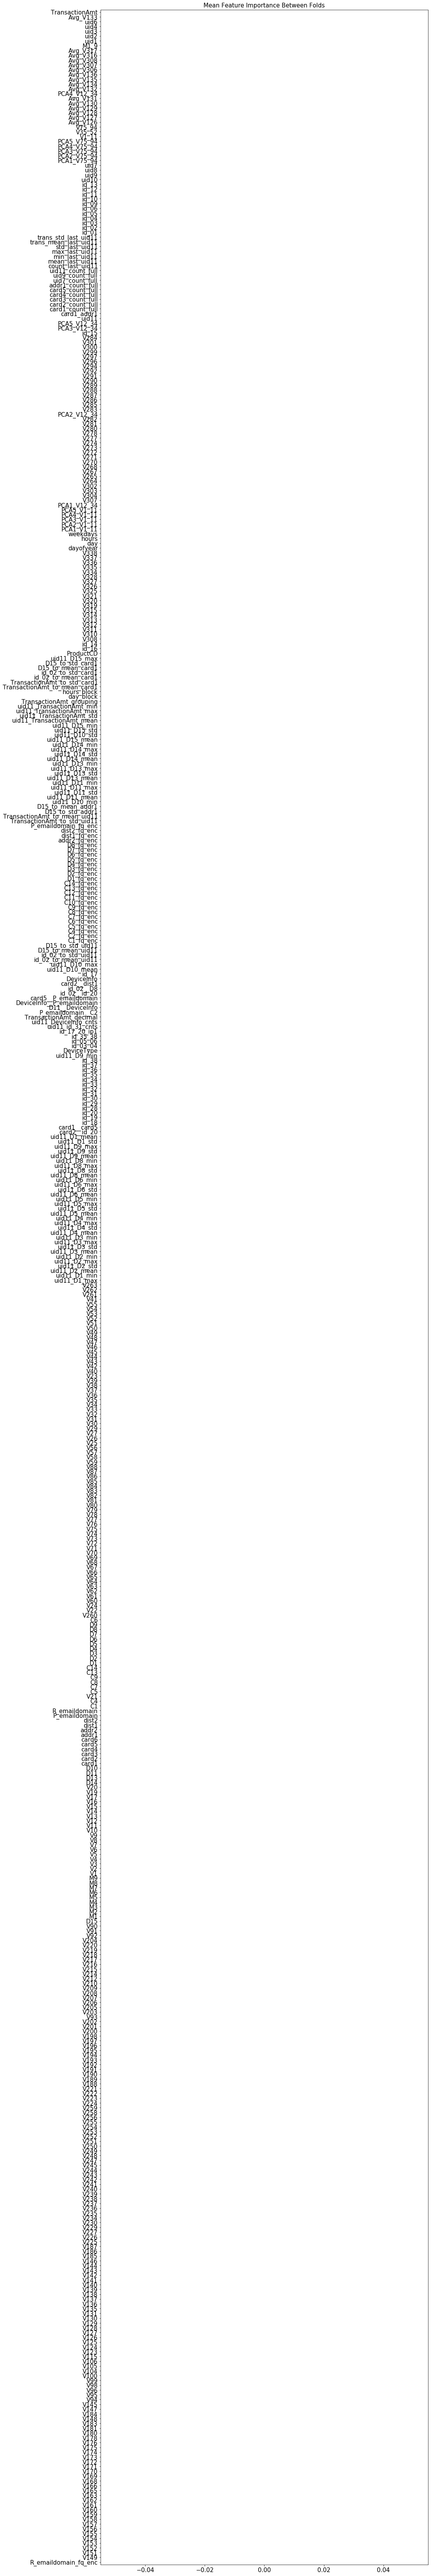

In [40]:
if LGBM :

    importance['Mean_Importance'] = importance.sum(axis=1) / splitcounts
    importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)

    plt.figure(figsize=(15, 120))
    sns.barplot(x='Mean_Importance', y=importance.index, data=importance)

    plt.xlabel('')
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.title('Mean Feature Importance Between Folds', size=15)

    plt.show()